In [1]:
import pandas as pd
import numpy as np

In [ ]:
dataCatEneroTrain = pd.read_csv("por_mes_train_no_null_features_categorios-Final-train/df_no_null_features_train_enero.csv").drop(columns = "Unnamed: 0")
dataCatFebreroTrain = pd.read_csv("por_mes_train_no_null_features_categorios-Final-train/df_no_null_features_train_febrero.csv").drop(columns = "Unnamed: 0")
dataCatMarzoTrain = pd.read_csv("por_mes_train_no_null_features_categorios-Final-train/df_no_null_features_train_marzo.csv").drop(columns = "Unnamed: 0")
dataCatAbrilTrain = pd.read_csv("por_mes_train_no_null_features_categorios-Final-train/df_no_null_features_train_abril.csv").drop(columns = "Unnamed: 0")
dataCatMayoTrain = pd.read_csv("por_mes_train_no_null_features_categorios-Final-train/df_no_null_features_train_mayo.csv").drop(columns = "Unnamed: 0")
labels = pd.read_csv("labels_training_set.csv").drop(columns = "person")
persons = pd.read_csv("labels_training_set.csv").drop(columns = "label")

In [3]:
trocafone = pd.read_csv("trocafone_kaggle_test.csv")

In [4]:
dataCatEneroTest = pd.read_csv("por_mes_test_no_null_features_categorios-Final_test/df_no_null_features_test_final_enero.csv").drop(columns = "Unnamed: 0")
dataCatFebreroTest = pd.read_csv("por_mes_test_no_null_features_categorios-Final_test/df_no_null_features_test_final_febrero.csv").drop(columns = "Unnamed: 0")
dataCatMarzoTest = pd.read_csv("por_mes_test_no_null_features_categorios-Final_test/df_no_null_features_test_final_marzo.csv").drop(columns = "Unnamed: 0")
dataCatAbrilTest = pd.read_csv("por_mes_test_no_null_features_categorios-Final_test/df_no_null_features_test_final_abril.csv").drop(columns = "Unnamed: 0")
dataCatMayoTest = pd.read_csv("por_mes_test_no_null_features_categorios-Final_test/df_no_null_features_test_final_mayo.csv").drop(columns = "Unnamed: 0")

In [5]:
trainSet = pd.concat([persons, dataCatEneroTrain, dataCatFebreroTrain, dataCatMarzoTrain, dataCatAbrilTrain, dataCatMayoTrain,labels], axis=1, sort=False)

In [8]:
testSet = pd.concat([dataCatEneroTest, dataCatFebreroTest, dataCatMarzoTest, dataCatAbrilTest, dataCatMayoTest], axis=1, sort=False)

#### SubMuestreo o undersample

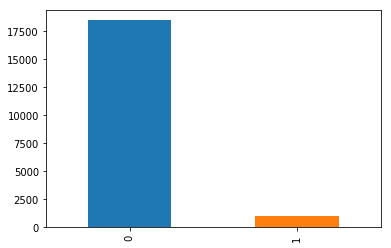

In [16]:
#Datos sin muestrear
import matplotlib.pyplot as plt

trainSet['label'].value_counts().plot(kind= 'bar')

In [9]:
#1.Encuentra el número de muestras que son conversiones
sizeConversiones = len(trainSet[trainSet['label'] == 1])

In [10]:
#2. Obtener índices de muestras de no conversiones.
no_conversiones_indices = trainSet[trainSet.label == 0].index 

In [11]:
#Muestras aleatorias de índices de no conversiones.
random_indices_no_conversiones = np.random.choice(no_conversiones_indices,sizeConversiones, replace=False)

In [12]:
#4. Encuentra los índices de muestras de conversiones.
conversiones = trainSet[trainSet.label == 1].index

In [13]:
#5. Índices de conversiones concat con muestras de no conversiones.
under_sample_indices = np.concatenate([conversiones,random_indices_no_conversiones])

In [14]:
#6 Obtener Balance Dataframe
under_sample = trainSet.loc[under_sample_indices]

In [15]:
under_sample = under_sample.sort_values(by='person')

### Visualización de datos submuestreados

In [11]:
under_sample['label'].value_counts().plot(kind='bar')

In [16]:
y = under_sample["label"].values
X = under_sample.iloc[:,:-1].drop(columns = "person").values

In [17]:
from sklearn.model_selection import train_test_split

#Spliteo con shuffle=False es decir ordenado
X_under_train, X_under_test, y_under_train, y_under_test =\
train_test_split(X,y,test_size = 0.4,shuffle = False)

In [14]:
print(X_under_train.shape)
print(y_under_train.shape)
print(X_under_test.shape)
print(y_under_test.shape)

(1176, 2446)
(1176,)
(784, 2446)
(784,)


In [18]:

import xgboost as xgb
import random
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score


/home/jonathan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/jonathan/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Hiper-parámetros:

* **num_boost_round:** cantidad de árboles a contruir (n_estimators)
* **metrics:** la métrica de evaluación a utilizar

* **early_stopping_rounds:** terminar antes si la métrica no mejora luego de una cantidad de pasadas
* **seed:** semilla para poder reproducir los resultados

In [19]:

def xgboost(self, train_X, train_y, test_X, params=None, num_boost_round=32):
        if params is None:
            params = {'objective': 'multi:softprob',
                      'eval_metric': 'mlogloss',
                      'colsample_bytree': 0.55,
                      'min_child_weight': 9.0, 
                      'subsample': 1.0, 
                      'learning_rate': 0.03,
                      'eta': 0.2, 
                      'max_depth': 7.0, 
                      'gamma': 0.75,
                      'num_class': 2,
                      'n_estimators': 580.0
                      }
        dtrain = xgb.DMatrix(train_X, label=train_y)
        dtest = xgb.DMatrix(test_X)
        self.bst = xgb.train(params, dtrain, num_boost_round=32)
        test_y = self.bst.predict(dtest)
        # self.classifier = XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=550, subsample=0.5, colsample_bytree=0.5, seed=seed)
        # self.classifier.fit(train_X, train_y)
        # test_y = self.classifier.predict_proba(test_X)[:, 1]
        return test_y 


In [20]:
params = {
    'n_estimators':500,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':6,
    'seed':1024,
    }

In [21]:
predict = xgboost(xgb,X_under_train,y_under_train, X_under_test,params,32)

[10:30:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=6
[10:30:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:30:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 2 pruned nodes, max_depth=6
[10:30:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[10:30:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:30:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:30:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:30:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:30:28] /work

In [23]:
T = testSet.values

In [25]:
predict_final = xgboost(xgb,X_under_train,y_under_train, T,params,32)

[10:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=6
[10:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 2 pruned nodes, max_depth=6
[10:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[10:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[10:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[10:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[10:34:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[10:34:05] /work

In [34]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
print(recall_score(y_under_test, predict.round()))
print(accuracy_score(y_under_test, predict.round()))

0.7786259541984732
0.7729591836734694


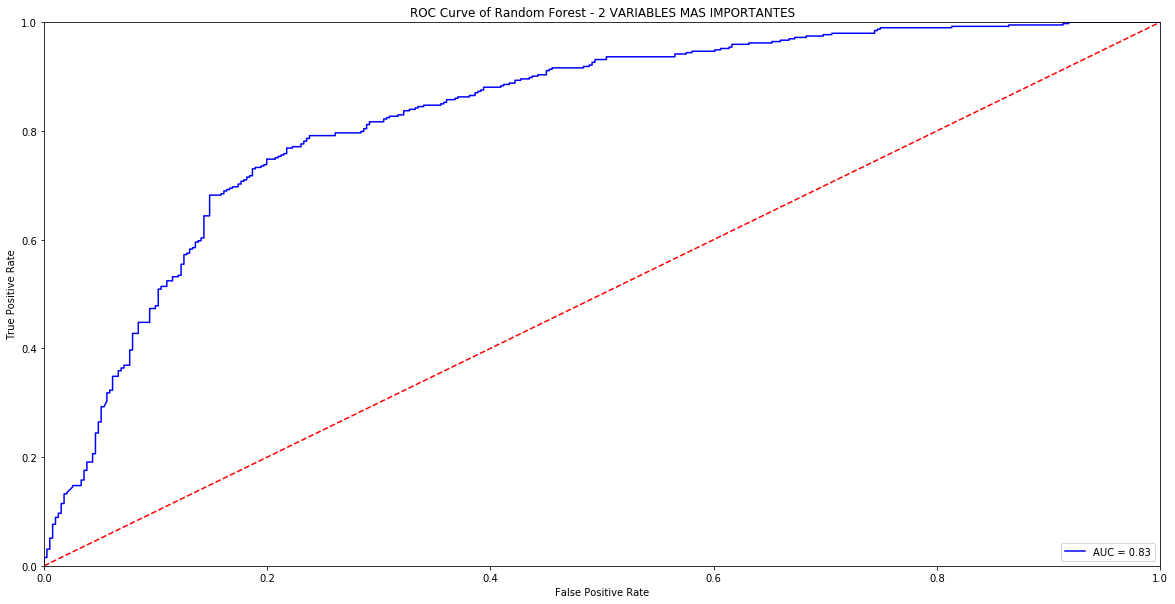

In [37]:
#GRAFICO DE CURVA AUR-ROC PARA MOST-IMPORTANT
#SOLO SE DEBE REEMPLAZAR LOS LABELS Y LAS PREDICCIONES EN roc_curve

fpr, tpr, threshold = roc_curve(y_under_test, predict)
roc_auc = auc(fpr, tpr)
#plt.title('Receiver Operating Characteristic')
plt.figure(figsize=(20,10))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forest - 2 VARIABLES MAS IMPORTANTES')
plt.show()

In [45]:
trocafone['label'] = predict_final

In [46]:
trocafone.to_csv("sub5_xGBoost.csv")

In [40]:
#print("Predict test set... ")
#test_prediction = gbm.predict(xgb.DMatrix(test[features],missing = -99), ntree_limit=gbm.best_iteration+1)
#score = average_precision_score(test[target].values, test_prediction)

#print('area under the precision-recall curve test set: {:.6f}'.format(score))